# Diabetic patients readmission rates preditction


In [205]:
# !pip install tqdm
# !pip install learn2learn
# !pip install tensorflow

In [1]:
# Importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


from sklearn.model_selection import train_test_split

# you may need to import sklearn.lda.LDA and sklearn.qda.QDA instead
# depending on which version you have installed
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, roc_curve, precision_recall_curve

#Standard Python libraries for data and visualisation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score



from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()

import time
%matplotlib inline



from learn2learn.algorithms.maml import MAML
from learn2learn.data import TaskDataset



# Project introduction

- Overview: <br>
This project is focusing on developing a predictive model to ascertain the likelihood of readmission for diabetes patients.
<br>

- Target:<br>
The main goal of this project is developing a powerful machine learning model which can predict the readmission rate of patient 

# Data loading
The following cells are used to load training and testing data for our prediction

In [207]:
train_data = pd.read_csv("Dataset/diabetic_data_training.csv")
test_data = pd.read_csv("Dataset/diabetic_data_test.csv")
mapping_info = pd.read_csv("Dataset/IDS_mapping.csv", header=None)
pd.set_option('display.max_columns', None)

In [208]:
# Function to handle different data types for plotting
def plot_column(ax, column, df):
    if df[column].dtype == 'object':
        # Check if binary
        if df[column].nunique() == 2:
            # Binary data visualization
            df[column].value_counts().plot(kind='bar', ax=ax)
        else:
            # Categorical data visualization
            df[column].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax)
    elif df[column].dtype == 'int64' or df[column].dtype == 'float64':
        # Numeric data visualization
        df[column].plot(kind='hist', bins=20, ax=ax)
    else:
        ax.text(0.5, 0.5, f"Unhandled data type for column: {column}", 
                fontsize=12, ha='center')
    ax.set_title(column)



In [209]:
# fig, axes = plt.subplots(nrows=13, ncols=4, figsize=(20, 65))
# fig.tight_layout(pad=5.0)


# for i, col in enumerate(train_data.columns):

#     plot_column(axes[i//4, i%4], col,train_data)


# plt.show()

# Data preprocessing
The following cells are used to preprocess the training and testing data. There are two main goals in our preprocessing data section of the code
- Change the string type data in our dataset to integer type data 
- Apply some applicable method to full up the missing value

In [210]:
# this part is used to change all string type data to integer type
# for the missing value, we will skip and process it at next step

# df = train_data.copy()

# df.drop(columns = ['weight','encounter_id','patient_nbr', 'examide', 'citoglipton',
# 'glimepiride-pioglitazone'],inplace=True)
# df.replace('?', np.nan, inplace=True)

# df_test = test_data.copy()
# df_test.drop(columns = ['weight','encounter_id','patient_nbr', 'examide', 'citoglipton',
# 'glimepiride-pioglitazone'],inplace=True)
# df_test.replace('?', np.nan, inplace=True)
df = train_data.copy()
df_test = test_data.copy()

One-Hot Encoding For race:
cons: One-hot encoding can lead to a significant increase in the dataset's dimensionality (a problem known as the "curse of dimensionality"), especially if the categorical feature has many unique values. This can increase the computational cost and may require more data to achieve good performance.
Dems Redct Would be apply, so it doesn't matter
pros: Map to a fix number implies an ordinal relationship between the categories which may not exist, but is ideal for non-ordinal categorical data. It's suitable for many machine learning models, especially those that assume no ordinal relationship between categories

Race Process
1. Remove missing since race is proved to be a significant impact to medical result.
2. One-hot encode race

In [211]:
def race_filter(df):
    """
    Remove missing value from race
    
    Parameters:
    df (pandas.dataframe): series containing a colum of the feature matrix.

    Return:
    Filtered dataframe free from ? for race
    """
    race_mask = (df['race'] != "?")
    df = df[race_mask]
    return df

In [212]:
df = race_filter(df)
df_encoded = pd.get_dummies(df, columns=["race"], prefix="race",dtype=int)

df_test = race_filter(df_test)
df_test_encoded = pd.get_dummies(df_test, columns=["race"], prefix="race",dtype=int)

Gender Process

1. Remove Unknown/Invalid and missing
2. One hot encode Gender

In [213]:
def gender_filter(df):
    """
    Remove missing value from race
    
    Parameters:
    df (pandas.dataframe): series containing a colum of the feature matrix.

    Return:
    Filtered dataframe free from ? for race
    """
    gender_mask = (df['gender'] != "Unknown/Invalid")
    df = df[gender_mask]
    return df

In [214]:
df_encoded = gender_filter(df_encoded)
df_test_encoded = gender_filter(df_test_encoded)
gender_mapping = {'Male':0,'Female':1}
df_encoded['gender'] = df_encoded['gender'].map(gender_mapping)
df_test_encoded['gender'] = df_test_encoded['gender'].map(gender_mapping)

encounter_id and patient_nbr Process 
1. n/a
2. Drop since it provide no info to the result

In [215]:
df_encoded.drop(columns=['encounter_id','patient_nbr'], inplace=True)
df_test_encoded.drop(columns=['encounter_id','patient_nbr'],inplace=True)

Age Process
1. n/a
2. Map age from range to mean

In [216]:
df_encoded['age'] = (df['age'].str.extract(r'(\d+)-(\d+)')[0].astype(int)+df['age'].str.extract(r'(\d+)-(\d+)')[1].astype(int))//2
df_test_encoded['age'] = (df_test['age'].str.extract(r'(\d+)-(\d+)')[0].astype(int)+df_test['age'].str.extract(r'(\d+)-(\d+)')[1].astype(int))//2

Weight Process
1. Drop Weight for too many missing values and no information to predict.
2. n/a

In [217]:
df_encoded.drop(columns=['weight'], inplace=True)
df_test_encoded.drop(columns=['weight'], inplace=True)

num_lab_procedures num_procedures num_medications number_outpatient number_emergency number_inpatient No need to be encode since no missing and integer.

diag_1,diag_2 and diag_3 Process:

Filte diag_1, diag_2 and diag_3 by number_diagnoses. If the amount of diagnoses in diag_1, diag_2 and diag_3 doesn't match the number_diagnoses, then remove.
Layer encoding diags according to the ICD-9 Code Category, drop original 3 diag

In [218]:
def diag_missing_value_filter(df):

    df['number_diagnoses'] = pd.to_numeric(df['number_diagnoses'], errors='coerce')
    mask = ((df['number_diagnoses'] <= 3) & (
            (3 - df[['diag_1', 'diag_2', 'diag_3']].apply(lambda x: x == "?").sum(axis=1)) >= df['number_diagnoses'])) | (
    (df['number_diagnoses'] > 3) & (df[['diag_1', 'diag_2', 'diag_3']].apply(lambda x: x == "?").sum(axis=1)) == 0) 
    df_filtered = df[mask].copy()

    return df_filtered

def diag_layer_encoding(df):

    # Define the encoding function
    def encode_element(element):
        encoding_result = [0] * 20  # Default encoding

        if pd.notna(element):
            if element[0].isdigit():
                element = float(element)
                # Encode based on numeric range
                if 1 <= element <= 139:
                    encoding_result[0] = 1
                elif 140 <= element <= 239:
                    encoding_result[1] = 1
                elif 240 <= element <= 279:
                    encoding_result[2] = 1
                elif 280 <= element <= 289:
                    encoding_result[3] = 1
                elif 290 <= element <= 319:
                    encoding_result[4] = 1
                elif 320 <= element <= 389:
                    encoding_result[5] = 1
                elif 390 <= element <= 459:
                    encoding_result[6] = 1
                elif 460 <= element <= 519:
                    encoding_result[7] = 1
                elif 520 <= element <= 579:
                    encoding_result[8] = 1
                elif 580 <= element <= 629:
                    encoding_result[9] = 1
                elif 630 <= element <= 679:
                    encoding_result[10] = 1
                elif 680 <= element <= 709:
                    encoding_result[11] = 1
                elif 710 <= element <= 739:
                    encoding_result[12] = 1
                elif 740 <= element <= 759:
                    encoding_result[13] = 1
                elif 760 <= element <= 779:
                    encoding_result[14] = 1
                elif 780 <= element <= 799:
                    encoding_result[15] = 1
                elif 800 <= element <= 999:
                    encoding_result[16] = 1
                # Add more conditions for other ranges if needed
            elif element[0].isalpha():
                # Encode based on string prefix
                if element.startswith('E'):
                    encoding_result[17] = 1
                elif element.startswith('V'):
                    encoding_result[18] = 1
                elif element.startswith('M'):
                    encoding_result[19] = 1
                # Add more conditions for other prefixes if needed

        return encoding_result

    for i in range(1,4):
        encoded_columns = df["diag_"+str(i)].apply(encode_element)

    # Create new columns with "diag_1" as a prefix
        for j in range(20):
            new_column_name = "diag_" + str(i)+"_"+ str(j+1)
            df[new_column_name] = encoded_columns.apply(lambda x: x[j])

    return df


In [219]:
df_encoded = diag_missing_value_filter(df_encoded)
df_encoded = diag_layer_encoding(df_encoded)
df_test_encoded = diag_missing_value_filter(df_test_encoded)
df_test_encoded = diag_layer_encoding(df_test_encoded)

for i in range(1,4):
        df_encoded.drop(columns=[f'diag_{i}'], inplace=True)
        df_test_encoded.drop(columns=[f'diag_{i}'], inplace=True)

number_diagnoses pass since no missing and integer max_glu_serum and A1Cresult Process: 
1. n/a 
2. index map to 0-3



In [220]:
max_glu_serum_mapping = {'>200': 2, '>300': 3, 'normal': 1}
A1Cresult_mapping = {'>8':3,'>7':2,'normal':1}

In [221]:
df_encoded['max_glu_serum'] = df_encoded['max_glu_serum'].map(max_glu_serum_mapping).fillna(0)
df_test_encoded['max_glu_serum'] = df_test_encoded['max_glu_serum'].map(max_glu_serum_mapping).fillna(0)

df_encoded["A1Cresult"] = df_encoded['A1Cresult'].map(A1Cresult_mapping).fillna(0)
df_test_encoded["A1Cresult"] = df_test_encoded['A1Cresult'].map(A1Cresult_mapping).fillna(0)

metformin repaglinide nateglinide chlorpropamide glimepiride acetohexamide glipizide glyburide tolbutamide pioglitazone rosiglitazone acarbose miglitol troglitazone tolazamide examide citoglipton insulin glyburide-metformin glipizide-metformin glimepiride-pioglitazone metformin-rosiglitazone metformin-pioglitazone Process:

1. drop 'examide', 'citoglipton','glimepiride-pioglitazone' and 'metformin-rosiglitazone' since single value observed
2. index map to 0-3

In [222]:
df_encoded.drop(columns=['examide', 'citoglipton','glimepiride-pioglitazone','metformin-rosiglitazone'],axis=1,inplace=True)
df_test_encoded.drop(columns=['examide', 'citoglipton','glimepiride-pioglitazone','metformin-rosiglitazone'],axis=1,inplace=True)
medics = ['metformin','repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
        'metformin-pioglitazone']
for i in medics:
    df_encoded.loc[df_encoded[i] == 'Up', [i]] = 3  
    df_encoded.loc[df_encoded[i] == 'Down', [i]] = 1 
    df_encoded.loc[df_encoded[i] == 'Steady', [i]] = 2 
    df_encoded.loc[df_encoded[i] == 'No', [i]] = 0
    df_test_encoded.loc[df_test_encoded[i] == 'Up', [i]] = 3  
    df_test_encoded.loc[df_test_encoded[i] == 'Down', [i]] = 1 
    df_test_encoded.loc[df_test_encoded[i] == 'Steady', [i]] = 2 
    df_test_encoded.loc[df_test_encoded[i] == 'No', [i]] = 0 
 

change and diabetesMed Process

1. n/a
2. binary map to 1/0

In [223]:
change_mapping = {'No':0,'Ch':1}
diabetesMed_mapping = {'No':0,'Yes':1}

df_encoded['change'] = df_encoded['change'].map(change_mapping)
df_encoded['diabetesMed'] = df_encoded['diabetesMed'].map(diabetesMed_mapping)

df_test_encoded['change'] = df_test_encoded['change'].map(change_mapping)
df_test_encoded['diabetesMed'] = df_test_encoded['diabetesMed'].map(diabetesMed_mapping)

readmitted Process: 
1. n/a 
2. index mapping, No as 0, >30 as 1 and <30 as most significant as 2 and drop readmitted for test

In [224]:
readmitted_mapping = {'NO':0,'<30':2,'>30':1}
df_encoded['readmitted'] = df_encoded['readmitted'].map(readmitted_mapping)
df_test_encoded['readmitted'] = df_test_encoded['readmitted'].map(readmitted_mapping)

y_readmitted = df_encoded["readmitted"]
y_test_readmitted = df_test_encoded["readmitted"]

df_encoded.drop(columns=["readmitted"],axis=1,inplace=True)
df_test_encoded.drop(columns=["readmitted"],axis=1,inplace=True)

'admission_type_id','discharge_disposition_id','admission_source_id' Process:
1. n/a
2. target encoding

In [225]:
X_train = df_encoded
Y_train = y_readmitted

features = ['admission_type_id','discharge_disposition_id','admission_source_id']

'''for name in names:
    category_means = df_encoded.groupby(name)['readmitted'].mean().reset_index()
    category_means.columns = [name,name+'_readmitted_Mean']
    df_encoded = pd.merge(df_encoded, category_means, on=name, how='left')
    df_encoded = df_encoded.drop(name, axis=1)'''


for feature in features:
    
    mean_col_name = f'{feature}_Encoded'
    means = X_train.join(Y_train).groupby(feature)['readmitted'].mean()
    df_encoded[mean_col_name] = df_encoded[feature].map(means)
    df_test_encoded[mean_col_name] = df_test_encoded[feature].map(means)

    df_encoded = df_encoded.drop(feature, axis=1)
    df_test_encoded = df_test_encoded.drop(feature, axis=1)

Payer Code Process:

1.2 RandomForestClassifier fill missing
1.3 KNN filling missing

2. index encoding payer code

In [226]:
def payer_code_index_encoding(df):
    df.loc[df['payer_code'] == 'MD', ['payer_code']] = 1
    df.loc[df['payer_code'] == 'MC', ['payer_code']] = 2
    df.loc[df['payer_code'] == 'HM', ['payer_code']] = 3
    df.loc[df['payer_code'] == 'UN', ['payer_code']] = 4
    df.loc[df['payer_code'] == 'BC', ['payer_code']] = 5
    df.loc[df['payer_code'] == 'CP', ['payer_code']] = 6
    df.loc[df['payer_code'] == 'SP', ['payer_code']] = 7
    df.loc[df['payer_code'] == 'SI', ['payer_code']] = 8
    df.loc[df['payer_code'] == 'CM', ['payer_code']] = 9
    df.loc[df['payer_code'] == 'DM', ['payer_code']] = 10
    df.loc[df['payer_code'] == 'CH', ['payer_code']] = 11
    df.loc[df['payer_code'] == 'PO', ['payer_code']] = 12
    df.loc[df['payer_code'] == 'WC', ['payer_code']] = 13
    df.loc[df['payer_code'] == 'OG', ['payer_code']] = 14
    df.loc[df['payer_code'] == 'OT', ['payer_code']] = 15
    df.loc[df['payer_code'] == 'MP', ['payer_code']] = 16
    df.loc[df['payer_code'] == 'FR', ['payer_code']] = 17
    return df

In [227]:
df_encoded = payer_code_index_encoding(df_encoded)
df_test_encoded = payer_code_index_encoding(df_test_encoded)

In [228]:
#separating the columns that contain null values and need to predicted.
payer_code_col = ['payer_code']
other_cols = list(df_encoded.columns)
other_cols.remove("payer_code")
other_cols.remove("medical_specialty")

Random Forst

In [229]:
payer_code_mask = (df_encoded["payer_code"] != "?")
df_notnans = df_encoded[payer_code_mask]
X_train, X_test, y_train, y_test = train_test_split(df_notnans[other_cols], df_notnans[payer_code_col].astype(int),
                                                    train_size=0.75,
                                                    random_state=1)

In [230]:


# rf = RandomForestClassifier()
# paramsgrid  = {'n_estimators': [100,200,400],
#                'max_depth': [25, 30,50,100],
#  'min_samples_leaf': [1, 2, 3],
#  'min_samples_split': [2, 5, 10]
#  }

# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = paramsgrid, n_iter = 5, cv = 3, verbose=2, random_state=1, n_jobs = -1)
 
# rf_random.fit(X_test, y_test.values.ravel())

In [231]:
# rf_random.best_params_

In [232]:
rf1 =(RandomForestClassifier(max_depth=100,n_estimators = 400,min_samples_leaf=1,min_samples_split=10))
rf1.fit(X_train, y_train.values.ravel())
score = rf1.score(X_test, y_test.values.ravel())

print(f"Score is {score}")

Score is 0.5637028196330002


KNN filling

In [233]:
# train_score = []
# test_score = []

# for i in range(6,30,2):

#     knn = KNeighborsClassifier(i)
#     knn.fit(X_train,y_train.values.ravel())
    
#     train_score.append(knn.score(X_train,y_train.values.ravel()))
#     test_score.append(knn.score(X_test,y_test.values.ravel()))

In [234]:
# plt.plot(train_score)
# plt.plot(test_score)

In [235]:
# knn2 =(KNeighborsClassifier(n_neighbors= 21))
# # # Fit on the train data
# knn2.fit(X_train, y_train.values.ravel())

# # # Check the prediction score
# score = knn2.score(X_test, y_test.values.ravel())
# print(f"The score on the testset is {score}")

56>53, therefore use randomforst for medical_specialty and payercode

In [236]:
payer_code_mask = (df_encoded["payer_code"] == "?")
df_notnans = df_encoded[payer_code_mask]
df_notnans["payer_code"] = rf1.predict(df_notnans[other_cols])
df_encoded.loc[payer_code_mask, 'payer_code'] = df_notnans['payer_code']


/tmp/ipykernel_2044/2230776403.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notnans["payer_code"] = rf1.predict(df_notnans[other_cols])


In [237]:
test_payer_code_mask = (df_test_encoded["payer_code"] == "?")
df_notnans = df_test_encoded[test_payer_code_mask]
df_notnans["payer_code"] = rf1.predict(df_notnans[other_cols])
df_test_encoded.loc[test_payer_code_mask, 'payer_code'] = df_notnans['payer_code']


/tmp/ipykernel_2044/1322505668.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notnans["payer_code"] = rf1.predict(df_notnans[other_cols])


medical_specialty Proces:
1. index encoding label
2. RF and KNN filling

In [238]:
train_medical_specialty = df_encoded["medical_specialty"].unique()
test_medical_specialty = df_test_encoded["medical_specialty"].unique()

train_medical_specialty = list(train_medical_specialty)
train_medical_specialty.remove("?")
train_medical_specialty = set(train_medical_specialty)

test_medical_specialty = list(test_medical_specialty)
test_medical_specialty.remove("?")
test_medical_specialty = set(test_medical_specialty)

In [239]:
medical_specialty_lable = train_medical_specialty.union(test_medical_specialty)

medical_specialty_nan_mask = (df_encoded['medical_specialty'] != "?")
medical_specialty_test_nan_mask = (df_test_encoded['medical_specialty'] != "?")

medical_specialty_dict = {element: index for index, element in enumerate(medical_specialty_lable)}


medical_specialty_test_to_be_encoded = df_test_encoded[medical_specialty_test_nan_mask]
medical_specialty_test_to_be_encoded['medical_specialty']= medical_specialty_test_to_be_encoded['medical_specialty'].map(lambda x: medical_specialty_dict[x])

medical_specialty_to_be_encoded = df_encoded[medical_specialty_nan_mask]
medical_specialty_to_be_encoded['medical_specialty'] = medical_specialty_to_be_encoded['medical_specialty'].map(lambda x: medical_specialty_dict[x])


/tmp/ipykernel_2044/2194747546.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medical_specialty_test_to_be_encoded['medical_specialty']= medical_specialty_test_to_be_encoded['medical_specialty'].map(lambda x: medical_specialty_dict[x])
/tmp/ipykernel_2044/2194747546.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medical_specialty_to_be_encoded['medical_specialty'] = medical_specialty_to_be_encoded['medical_specialty'].map(lambda x: medical_specialty_dict[x])


In [240]:
df_encoded['medical_specialty'] = medical_specialty_to_be_encoded['medical_specialty']
df_test_encoded['medical_specialty'] = medical_specialty_test_to_be_encoded['medical_specialty']


RF for medical_specialty

In [241]:
medical_specialty_mask = df_encoded["medical_specialty"].notnull()
df_notnans = df_encoded[medical_specialty_mask]
X_train, X_test, y_train, y_test = train_test_split(df_notnans[other_cols], df_notnans["medical_specialty"].astype(int),
                                                    train_size=0.75,
                                                    random_state=1)


rf = RandomForestClassifier()
paramsgrid  = {'n_estimators': [100,200,400],
               'max_depth': [25, 30,50,100],
 'min_samples_leaf': [1, 2, 3],
 'min_samples_split': [2, 5, 10]
 }

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = paramsgrid, n_iter = 5, cv = 3, verbose=2, random_state=1, n_jobs = -1)
 
rf_random.fit(X_test, y_test.values.ravel())

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/home/codespace/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


[CV] END max_depth=100, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   2.9s
[CV] END max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   3.2s
[CV] END max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   3.1s
[CV] END max_depth=100, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END max_depth=100, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END max_depth=100, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   7.2s
[CV] END max_depth=100, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   6.9s
[CV] END max_depth=100, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   7.1s


/home/codespace/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=100, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   6.9s
[CV] END max_depth=100, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   6.6s
[CV] END max_depth=100, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   6.8s
[CV] END max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=400; total time=   5.5s
[CV] END max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=400; total time=   5.6s
[CV] END max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=400; total time=   4.2s


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'max_depth': [25, 30, 50, 100],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 400]},
                   random_state=1, verbose=2)

In [242]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_depth': 100}

In [243]:
rf1 =(RandomForestClassifier(max_depth=100,n_estimators = 400,min_samples_leaf=2,min_samples_split=2))
rf1.fit(X_train, y_train.values.ravel())
score = rf1.score(X_test, y_test.values.ravel())

print(f"Score is {score}")

Score is 0.5367375637194586


KNN for medical_specialty

In [244]:
# train_score = []
# test_score = []

# for i in range(5,100,2):

#     knn = KNeighborsClassifier(i)
#     knn.fit(X_train,y_train.values.ravel())
#     trianscore = knn.score(X_train,y_train.values.ravel())
#     testscore = knn.score(X_test,y_test.values.ravel())
#     train_score.append(trianscore)
#     test_score.append(testscore)
#     print(f"train score is: {trianscore}, test score is: {testscore}")

In [245]:
# plt.plot(train_score)
# plt.plot(test_score)

In [246]:
# knn2 =(KNeighborsClassifier(n_neighbors= 25))
# # # Fit on the train data
# knn2.fit(X_train, y_train.values.ravel())

# # # Check the prediction score
# score = knn2.score(X_test, y_test.values.ravel())
# print(f"The score on the testset is {score}")

53>35, therefore use RF

In [247]:
medical_specialty_code_mask = df_encoded["medical_specialty"].isna()
df_notnans = df_encoded[medical_specialty_code_mask]
df_notnans["medical_specialty"] = rf1.predict(df_notnans[other_cols])
df_encoded.loc[medical_specialty_code_mask, 'medical_specialty'] = df_notnans['medical_specialty']


/tmp/ipykernel_2044/2029475354.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notnans["medical_specialty"] = rf1.predict(df_notnans[other_cols])


In [248]:
medical_specialty_code_mask = df_test_encoded["medical_specialty"].isna()
df_notnans = df_test_encoded[medical_specialty_code_mask]
df_notnans["medical_specialty"] = rf1.predict(df_notnans[other_cols])
df_test_encoded.loc[medical_specialty_code_mask, 'medical_specialty'] = df_notnans['medical_specialty']


/tmp/ipykernel_2044/156946292.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notnans["medical_specialty"] = rf1.predict(df_notnans[other_cols])


In [249]:
df_encoded

gender  age  time_in_hospital payer_code  medical_specialty  \
0           1   15                 3          1                1.0   
1           1   25                 2          1                1.0   
2           0   35                 2          7                1.0   
3           0   45                 1          5                1.0   
4           0   55                 3          2                9.0   
...       ...  ...               ...        ...                ...   
91584       0   75                 3          2                1.0   
91585       1   85                 5          2                1.0   
91586       0   75                 1          2                1.0   
91587       1   85                10          2               41.0   
91588       0   75                 6          2               10.0   

       num_lab_procedures  num_procedures  num_medications  number_outpatient  \
0                      59               0               18                  0   
1                      11               5               13                  2   
2                      44               1               16                  0   
3                      51               0                8                  0   
4                      31               6               16                  0   
...                   ...             ...              ...                ...   
91584                  51               0               16                  0   
91585                  33               3               18                  0   
91586                  53               0                9                  1   
91587                  45               2               21                  0   
91588                  13               3                3                  0   

       number_emergency  number_inpatient  number_diagnoses  max_glu_serum  \
0                     0                 0                 9            0.0   
1                     0                 1                 6            0.0   
2                     0                 0                 7            0.0   
3                     0                 0                 5            0.0   
4                     0                 0                 9            0.0   
...                 ...               ...               ...            ...   
91584                 0                 0                 9            0.0   
91585                 0                 1                 9            0.0   
91586                 0                 0                13            0.0   
91587                 0                 1                 9            0.0   
91588                 0                 0                 9            0.0   

       A1Cresult metformin repaglinide nateglinide chlorpropamide glimepiride  \
0            0.0         0           0           0              0           0   
1            0.0         0           0           0              0           0   
2            0.0         0           0           0              0           0   
3            0.0         0           0           0              0           0   
4            0.0         0           0           0              0           0   
...          ...       ...         ...         ...            ...         ...   
91584        3.0         2           0           0              0           0   
91585        0.0         0           0           0              0           0   
91586        0.0         2           0           0              0           0   
91587        0.0         0           0           0              0           0   
91588        0.0         0           0           0              0           0   

      acetohexamide glipizide glyburide tolbutamide pioglitazone  \
0                 0         0         0           0            0   
1                 0         2         0           0            0   
2                 0         0         0           0            0   
3          

In [250]:
# this part will recognise the ?, the missing value in training data
# When we have recognised it, we will use **** method to full up it
# the method we can discuss: 
#   delete
#   mean,median or mode
#   knn to predict
#   Multiple Imputation

In [251]:

# predict_nan = df_encoded.copy()


# df_real_ms_index = predict_nan.index[predict_nan['medical_specialty'] != 0]
# unique_rows_index = predict_nan.index[predict_nan['medical_specialty'].duplicated(keep=False)]
# df_real_ms_index_total = df_real_ms_index.join(unique_rows_index,how = 'inner')

# df_real_pc_index = predict_nan.index[predict_nan['payer_code'] != 0]
# unique_rows_index = predict_nan.index[predict_nan['payer_code'].duplicated(keep=False)]
# df_real_pc_index_total = df_real_pc_index.join(unique_rows_index,how = 'inner')

# df_real_ms = predict_nan.loc[df_real_ms_index_total,['medical_specialty']]
# df_real_pc = predict_nan.loc[df_real_pc_index_total,['payer_code']]

# predict_nan.drop(columns = ['medical_specialty','payer_code'],inplace = True)

# df_data_train_ms = predict_nan.loc[df_real_ms_index_total]
# df_data_predict_ms = predict_nan.loc[~predict_nan.index.isin(df_real_ms_index)]

# df_data_train_pc = predict_nan.loc[df_real_pc_index_total]
# df_data_predict_pc = predict_nan.loc[~predict_nan.index.isin(df_real_pc_index)]

In [252]:
# # this part will reduce the dimension our training data

# missing_value_predict_model = HistGradientBoostingClassifier(max_iter=100)
# missing_value_predict_model.fit(df_data_train_ms,df_real_ms['medical_specialty'])
# df_encoded['medical_specialty'].loc[~df_encoded['medical_specialty'].index.isin(df_real_ms_index)] = missing_value_predict_model.predict(df_data_predict_ms)

# missing_value_predict_model = HistGradientBoostingClassifier(max_iter=100)
# missing_value_predict_model.fit(df_data_train_pc,df_real_pc)
# df_encoded['payer_code'].loc[~df_encoded['payer_code'].index.isin(df_real_pc_index)] = missing_value_predict_model.predict(df_data_predict_pc)

Normalization age, medical_specialty, num_lab_procedures and num_medications to keep the same order of magnitude

In [253]:
scaler = MinMaxScaler(feature_range=(0, 1))
features_to_scale = ["age","medical_specialty","num_lab_procedures","num_medications"]
df_encoded[features_to_scale] = scaler.fit_transform(df_encoded[features_to_scale])
df_test_encoded[features_to_scale] = scaler.fit_transform(df_test_encoded[features_to_scale])

In [254]:
df_encoded

gender       age  time_in_hospital payer_code  medical_specialty  \
0           1  0.111111                 3          1           0.014085   
1           1  0.222222                 2          1           0.014085   
2           0  0.333333                 2          7           0.014085   
3           0  0.444444                 1          5           0.014085   
4           0  0.555556                 3          2           0.126761   
...       ...       ...               ...        ...                ...   
91584       0  0.777778                 3          2           0.014085   
91585       1  0.888889                 5          2           0.014085   
91586       0  0.777778                 1          2           0.014085   
91587       1  0.888889                10          2           0.577465   
91588       0  0.777778                 6          2           0.140845   

       num_lab_procedures  num_procedures  num_medications  number_outpatient  \
0                0.442748               0           0.2125                  0   
1                0.076336               5           0.1500                  2   
2                0.328244               1           0.1875                  0   
3                0.381679               0           0.0875                  0   
4                0.229008               6           0.1875                  0   
...                   ...             ...              ...                ...   
91584            0.381679               0           0.1875                  0   
91585            0.244275               3           0.2125                  0   
91586            0.396947               0           0.1000                  1   
91587            0.335878               2           0.2500                  0   
91588            0.091603               3           0.0250                  0   

       number_emergency  number_inpatient  number_diagnoses  max_glu_serum  \
0                     0                 0                 9            0.0   
1                     0                 1                 6            0.0   
2                     0                 0                 7            0.0   
3                     0                 0                 5            0.0   
4                     0                 0                 9            0.0   
...                 ...               ...               ...            ...   
91584                 0                 0                 9            0.0   
91585                 0                 1                 9            0.0   
91586                 0                 0                13            0.0   
91587                 0                 1                 9            0.0   
91588                 0                 0                 9            0.0   

       A1Cresult metformin repaglinide nateglinide chlorpropamide glimepiride  \
0            0.0         0           0           0              0           0   
1            0.0         0           0           0              0           0   
2            0.0         0           0           0              0           0   
3            0.0         0           0           0              0           0   
4            0.0         0           0           0              0           0   
...          ...       ...         ...         ...            ...         ...   
91584        3.0         2           0           0              0           0   
91585        0.0         0           0           0              0           0   
91586        0.0         2           0           0              0           0   
91587        0.0         0           0           0              0           0   
91588        0.0         0           0           0              0           0   

      acetohexamide glipizide glyburide tolbutamide pioglitazone  \
0                 0         0         0           0            0   
1                 0         2         0           0            0   
2                 0

In [2]:
df_encoded.to_csv('encoded_train.csv',index=False)
df_test_encoded.to_csv('encoded_test.csv',index=False)
y_readmitted.to_csv('y_readmitted.csv',index=False)
y_test_readmitted.to_csv('y_test_readmitted.csv',index=False)

NameError: name 'df_encoded' is not defined

In [3]:
df_encoded = pd.read_csv('encoded_train.csv')
df_test_encoded = pd.read_csv('encoded_test.csv')


In [61]:
y_readmitted = pd.read_csv('y_readmitted.csv').to_numpy()
y_test_readmitted = pd.read_csv('y_test_readmitted.csv').to_numpy()

pandas.core.frame.DataFrame

In [4]:
df_encoded

gender       age  time_in_hospital  payer_code  medical_specialty  \
0           1  0.111111                 3           1           0.014085   
1           1  0.222222                 2           1           0.014085   
2           0  0.333333                 2           7           0.014085   
3           0  0.444444                 1           5           0.014085   
4           0  0.555556                 3           2           0.126761   
...       ...       ...               ...         ...                ...   
89356       0  0.777778                 3           2           0.014085   
89357       1  0.888889                 5           2           0.014085   
89358       0  0.777778                 1           2           0.014085   
89359       1  0.888889                10           2           0.577465   
89360       0  0.777778                 6           2           0.140845   

       num_lab_procedures  num_procedures  num_medications  number_outpatient  \
0                0.442748               0           0.2125                  0   
1                0.076336               5           0.1500                  2   
2                0.328244               1           0.1875                  0   
3                0.381679               0           0.0875                  0   
4                0.229008               6           0.1875                  0   
...                   ...             ...              ...                ...   
89356            0.381679               0           0.1875                  0   
89357            0.244275               3           0.2125                  0   
89358            0.396947               0           0.1000                  1   
89359            0.335878               2           0.2500                  0   
89360            0.091603               3           0.0250                  0   

       number_emergency  ...  diag_3_14  diag_3_15  diag_3_16  diag_3_17  \
0                     0  ...          0          0          0          0   
1                     0  ...          0          0          0          0   
2                     0  ...          0          0          0          0   
3                     0  ...          0          0          0          0   
4                     0  ...          0          0          0          0   
...                 ...  ...        ...        ...        ...        ...   
89356                 0  ...          0          0          0          0   
89357                 0  ...          0          0          1          0   
89358                 0  ...          0          0          0          0   
89359                 0  ...          0          0          0          1   
89360                 0  ...          0          0          1          0   

       diag_3_18  diag_3_19  diag_3_20  admission_type_id_Encoded  \
0              0          0          0                   0.590542   
1              0          1          0                   0.590542   
2              0          0          0                   0.590542   
3              0          0          0                   0.590542   
4              0          0          0                   0.585561   
...          ...        ...        ...                        ...   
89356          0          0          0                   0.590542   
89357          0          0          0                   0.590542   
89358          0          0          0                   0.590542   
89359          0          0          0                   0.585561   
89360          0          0          0                   0.590542   

       discharge_disposition_id_Encoded  admission_source_id_Encoded  
0                              0.547861                     0.612805  
1                              0.547861                     0.612805  
2                              0.547861                     0.612805  
3                              0.547861                     0.612805  
4                       

Dems Redct
1. PCA/PPCA
2. LDA/QDA
3. following to T-SNE
3. Autoencoders
4. Unsupervised Algorithmn

In [258]:
               
def plot_2d(projected, y_train, title):
    fig = plt.figure(figsize=(8, 6), dpi=80)
    ax = fig.add_subplot(111)

    p = ax.scatter(projected[:, 0], projected[:, 1],
                c=y_train, edgecolor='none', alpha=0.5,
                  cmap='tab10')
    ax.set_xlabel('component 1')
    ax.set_ylabel('component 2')
    ax.set_title(title)
    fig.colorbar(p);
    
def print_results(y_pred, y_test):
    mat = confusion_matrix(y_test, y_pred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label');

    print("Accuracy on test set: ", accuracy_score(y_test, y_pred))


Correlation

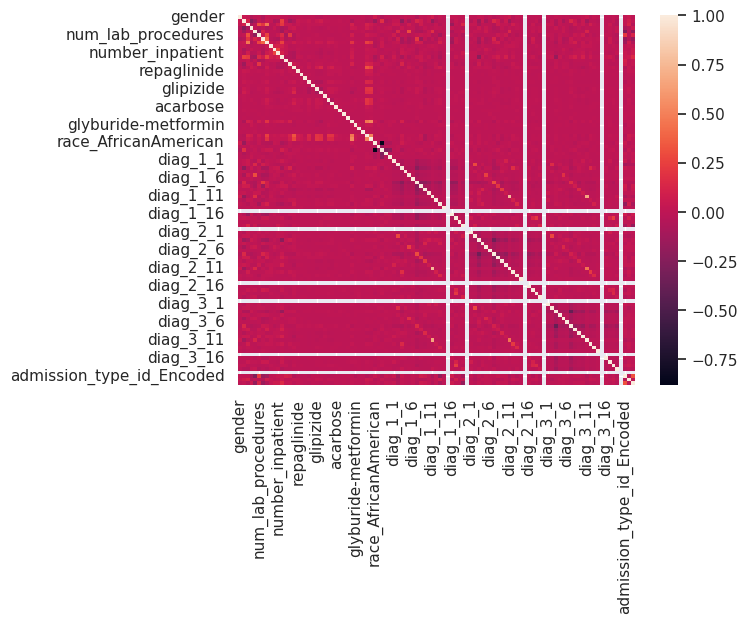

In [259]:
corr = df_encoded.corr()

from seaborn import heatmap
heatmap(corr)

plt.show()

In [260]:
pca = PCA(n_components=0.95)  # Keep 95% of the variance
pca_result = pca.fit_transform(df_encoded)
test_pca_result = pca.fit_transform(df_test_encoded)


Naive Bayes for demstionality reduction result evaluation, This algorithm is very fast and works well with high-dimensional data. It assumes independence between the features, which may or may not hold after dimensionality reduction. According to the covr graph, mostly independent.

In [65]:
def naive_bayes_score(train, label, test, test_lable):
    nb = GaussianNB()
    nb.fit(train, label)
    y_nb = nb.predict(test)
    mse = np.mean((test_lable - y_nb) ** 2)
    print(y_nb.shape,test_lable.shape)
    return mse

In [276]:
non_dr_score = naive_bayes_score(df_encoded,y_readmitted,df_test_encoded,y_test_readmitted)
print(f"Full param mse score is {non_dr_score}")

Full param mse score is 2.425655976676385


In [270]:
pca_score = naive_bayes_score(pca_result,y_readmitted,test_pca_result,y_test_readmitted)
print(f"PCA mse score is {pca_score}")

PCA mse score is 0.7285613752890319


T-SNE reduce to 26 as PCA did for comparasion

In [282]:
tsne = TSNE(n_components=3, perplexity=30, n_iter=300)
tsne_result = tsne.fit_transform(df_encoded)

In [283]:
tsne = TSNE(n_components=3, perplexity=30, n_iter=300)
tsne_test_result = tsne.fit_transform(df_test_encoded)

In [284]:
tsne_score = naive_bayes_score(tsne_result,y_readmitted,tsne_test_result,y_test_readmitted)
print(f"tsne mse score is {tsne_score}")

tsne mse score is 0.7884789383733789


PCA and t-sne

In [289]:
tsne = TSNE(n_components=3, perplexity=30, n_iter=300)
pca_tsne_trian_result = tsne.fit_transform(pca_result)

In [286]:
tsne = TSNE(n_components=3, perplexity=30, n_iter=300)
pca_tsne_result = tsne.fit_transform(test_pca_result)

In [290]:
pca_tsne_score = naive_bayes_score(pca_tsne_trian_result,y_readmitted,pca_tsne_result,y_test_readmitted)
print(f"pca-tsne mse score is {pca_tsne_score}")

pca-tsne mse score is 0.7851613551824671


In [5]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

2024-01-17 14:46:05.196752: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-17 14:46:05.196860: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-17 14:46:05.500245: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-17 14:46:06.108463: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-17 14:46:09.017269: W tensorflow/compiler/tf2

In [67]:
# Number of features in your dataset
n_features = len(df_encoded.columns)  # Change this to the actual number of features

# Define the encoder
input_layer = Input(shape=(n_features,))
encoder = Dense(64, activation='relu')(input_layer)
encoder = Dense(32, activation='relu')(encoder)

# Define the bottleneck
bottleneck = Dense(10, activation='relu')(encoder)  # This is the latent space representation

# Define the decoder (mirror the encoder)
decoder = Dense(32, activation='relu')(bottleneck)
decoder = Dense(64, activation='relu')(decoder)

# Output layer
output_layer = Dense(n_features, activation='sigmoid')(decoder)  # Use 'sigmoid' or 'relu'

# Define the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

In [68]:
df_encoded = df_encoded.astype('float32')
df_test_encoded = df_test_encoded.astype('float32')
autoencoder.fit(df_encoded, df_encoded,  # The target is the input data itself
                epochs=200,
                batch_size=128,
                shuffle=True,
                validation_data=(df_test_encoded, df_test_encoded))

Epoch 1/200


699/699 [==============================] - 2s 1ms/step - loss: 0.8700 - val_loss: 0.8424
Epoch 2/200
699/699 [==============================] - 1s 1ms/step - loss: 0.8425 - val_loss: 0.8354
Epoch 3/200
699/699 [==============================] - 1s 1ms/step - loss: 0.8387 - val_loss: 0.8332
Epoch 4/200
699/699 [==============================] - 1s 1ms/step - loss: 0.8367 - val_loss: 0.8313
Epoch 5/200
699/699 [==============================] - 1s 1ms/step - loss: 0.8345 - val_loss: 0.8300
Epoch 6/200
699/699 [==============================] - 1s 1ms/step - loss: 0.8334 - val_loss: 0.8285
Epoch 7/200
699/699 [==============================] - 1s 1ms/step - loss: 0.8328 - val_loss: 0.8282
Epoch 8/200
699/699 [==============================] - 1s 1ms/step - loss: 0.8323 - val_loss: 0.8275
Epoch 9/200
699/699 [==============================] - 1s 1ms/step - loss: 0.8320 - val_loss: 0.8272
Epoch 10/200
699/699 [==============================] - 1s 1ms/step - loss: 0.8317 - val_loss: 0.8271
E

In [69]:
encoder_model = Model(inputs=input_layer, outputs=bottleneck)
compressed_data = encoder_model.predict(df_encoded)
reconstructed_data = autoencoder.predict(df_encoded)

compressed_test_data = encoder_model.predict(df_test_encoded)
reconstructed_test_data = autoencoder.predict(df_test_encoded)

311/311 [==============================] - 0s 732us/step


In [70]:
AE_score = naive_bayes_score(reconstructed_data,y_readmitted,reconstructed_test_data,y_test_readmitted)
print(f"AE mse score is {AE_score}")

/home/codespace/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(9947,) (9947, 1)
AE mse score is 0.6954209880982861


# Model Building
We will build two models: 
1. A traditional machine learning model using Random Forest.
2. A deep learning model using PyTorch.


At the first step we will try to use the Random Forest method to get the result

In [ ]:
# the code for Random Forest algorithm

In [ ]:
# the code for Nerual Network

# Model Training


In [199]:
df_encoded['A1Cresult'].value_counts()

A1Cresult
0.0    76279
3.0     7398
1.0     4479
2.0     3430
Name: count, dtype: int64

In [200]:
(df_normalized.astype(float) < 0).any()

age                                         True
time_in_hospital                            True
payer_code                                  True
medical_specialty                           True
num_lab_procedures                          True
num_procedures                              True
num_medications                             True
number_outpatient                           True
number_emergency                            True
number_inpatient                            True
max_glu_serum                               True
A1Cresult                                   True
metformin                                   True
repaglinide                                 True
nateglinide                                 True
chlorpropamide                              True
glimepiride                                 True
acetohexamide                               True
glipizide                                   True
glyburide                                   True
tolbutamide         

In [205]:
# training loop
# Random Forest
from sklearn.feature_selection import SelectKBest, chi2

# 选择最好的K个特征


Y = df_encoded['readmitted']
#df_normalized = pd.DataFrame(scaler.fit_transform(df_encoded), columns=df_encoded.columns)
X = df_encoded.drop('readmitted', axis=1)

selector = SelectKBest(chi2, k=10)
X_new = selector.fit_transform(X, Y)


rf_classifier = HistGradientBoostingClassifier(max_iter=100, random_state=42)
rf_classifier.fit(X, Y)

# Nerual Network

HistGradientBoostingClassifier(random_state=42)

In [202]:

classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(X, Y)

RandomForestClassifier()

# Model Evaluation

In [207]:
# use testing dataset to predict
Y_test = df_test_encoded['readmitted']
#df_test_normalized = pd.DataFrame(scaler.fit_transform(df_test_encoded), columns=df_test_encoded.columns)
X_test = df_test_encoded.drop('readmitted', axis=1)
#X_test = selector.transform(X_test)

Y_pred = rf_classifier.predict(X_test)
print(Y_pred)
print(Y_test)
print(accuracy_score(Y_test,Y_pred))

[0 0 0 ... 0 0 2]
0        0
1        2
2        0
3        0
4        2
        ..
10172    2
10173    0
10174    0
10175    1
10176    2
Name: readmitted, Length: 10177, dtype: int64
0.5851429694408962


In [208]:
Y_pred = classifier.predict(df_test_encoded.drop('readmitted', axis=1))
print(Y_pred)
print(Y_test)
print(accuracy_score(Y_test,Y_pred))

[0 0 0 ... 0 0 2]
0        0
1        2
2        0
3        0
4        2
        ..
10172    2
10173    0
10174    0
10175    1
10176    2
Name: readmitted, Length: 10177, dtype: int64
0.5586125577282107
